# 2018 CDC Natality Data Set

Exploring who gets prenatal care

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.optimize import minimize

warnings.filterwarnings('ignore')
my_cmap = cm.get_cmap('tab10')

## Data Cleaning

In [2]:
# df = pd.read_csv('../data/NBER/natl2018us.csv')

# # Keep only single births and first pregnancy
# df = df[df['dplural'] == 1]
# df = df[df['ilp_r'] == 888]

# # Subset of indicators to consider
# df = df[['mager9', 'mbstate_rec', 'mracehisp', 'meduc', 'precare5', 'wic', 'pay_rec']]

# # Get rid of unknowns
# df = df[df['mbstate_rec'] != 3] # Unknown nativity
# df = df[df['mracehisp'] != 8]   # Unknown race
# df = df[df['meduc'] != 9]       # Unknown education
# df = df[df['precare5'] != 5]    # Unknown prenatal care
# df = df[df['wic'] != 'U']       # Unknown WIC
# df = df[df['pay_rec'] != 9]     # Unknown payment method

# # Change encoding for nativity
# df['mbstate_rec'] = df.apply(lambda row: int(row['mbstate_rec'] == 1), axis=1)

# # Change encoding for WIC
# df['wic'] = df.apply(lambda row: int(row['wic'] == 'Y'), axis=1)

# # Add column for prenatal care
# df['prenatal'] = df.apply(lambda row: int(row['precare5'] != 4), axis=1)

# # Save subset
# df.to_csv('../data/NBER/natl2018us_subset.csv', index=False)
df = pd.read_csv('../data/NBER/natl2018us_subset.csv')

## Indicators

In [3]:
# Month prenatal care began (`precare5`)
month_dict = {
    1: '1st-3rd month',
    2: '4th-6th month',
    3: '7th-final month',
    4: 'No prenatal care'
}

# Mother's age (`mager9`)
age_dict = {
    1: 'Under 15 years',
    2: '15-19 years',
    3: '20-24 years',
    4: '25-29 years',
    5: '30-34 years',
    6: '35-39 years',
    7: '40-44 years',
    8: '45-49 years',
    9: '50-54 years'
}

# Mother's nativity (`mbstate_rec`)
nat_dict = {
    0: 'Born outside the US',
    1: 'Born in the US'
}

# Mother's race/Hispanic origin (`mracehisp`)
race_dict = {
    1: 'White',
    2: 'Black',
    3: 'AIAN',
    4: 'Asian',
    5: 'NHOPI',
    6: 'More than one race',
    7: 'Hispanic'
}

# Mother's education (`meduc`)
educ_dict = {
    1: '8th grade or less',
    2: '9th through 12th with no diploma',
    3: 'High school graduate or GED completed',
    4: 'Some college credit, but not a degree',
    5: 'Associate degree',
    6: "Bachelor's degree",
    7: "Master's degree",
    8: 'Doctorate'
}

# WIC (`wic`)
wic_dict = {
    0: 'No',
    1: 'Yes'
}

# Payment source for delivery (`pay_rec`)  
pay_dict = {
    1: 'Medicaid',
    2: 'Private Insurance',
    3: 'Self Pay',
    4: 'Other'
}

## Who gets prenatal care?

In [4]:
def plot_care(col, col_name, col_dict):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    col_labels = [col_dict[ii] for ii in np.sort(df[col].unique())]
    
    # Plot entire data set
    temp = get_plot_data(col, col_name, col_dict, df)
    sns.barplot(x=col_name, y='care', data=temp, ax=ax[0])
    ax[0].set_xticklabels(col_labels, rotation=90)
    ax[0].set_ylabel(f"Percent With Prenatal Care")
    ax[0].set_title('Full Data Set')
    
    # Plot random subset with equal counts
    temp = pd.DataFrame()
    for seed in np.arange(0, 25):
        df_rand = get_subset(seed)
        temp = pd.concat([temp, get_plot_data(col, col_name, col_dict, df_rand)])
    sns.boxplot(x=col_name, y='care', data=temp, ax=ax[1])
    ax[1].set_xticklabels(col_labels, rotation=90)
    ax[1].set_ylabel(f"Percent With Prenatal Care")
    ax[1].set_title('Random Subsets with Equal Counts Care/No Care')
    
def get_plot_data(col, col_name, col_dict, df):
    col_list = []
    care_list = []
    for ii in np.sort(df[col].unique()):
        df_sub = df[df[col] == ii]
        col_list.append(col_dict[ii])
        care_list.append(100*len(df_sub[df_sub['prenatal'] == 1])/len(df_sub))
    temp = pd.DataFrame({
        col_name: col_list,
        'care': care_list
    })
    return temp

def get_subset(seed):
    np.random.seed(seed)
    idx_0 = df[df['prenatal'] == 0].index.tolist()
    idx_1 = df[df['prenatal'] == 1].index.tolist()
    n = np.min([len(idx_0), len(idx_1)])
    idx = np.random.choice(idx_0, n, replace=False).tolist() + \
          np.random.choice(idx_1, n, replace=False).tolist()
    return df.loc[idx]

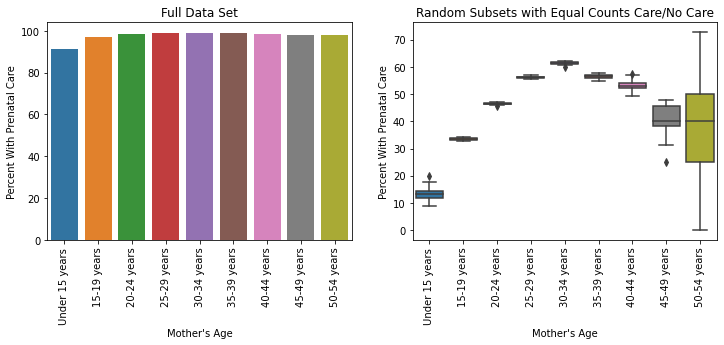

In [5]:
plot_care('mager9', "Mother's Age", age_dict)

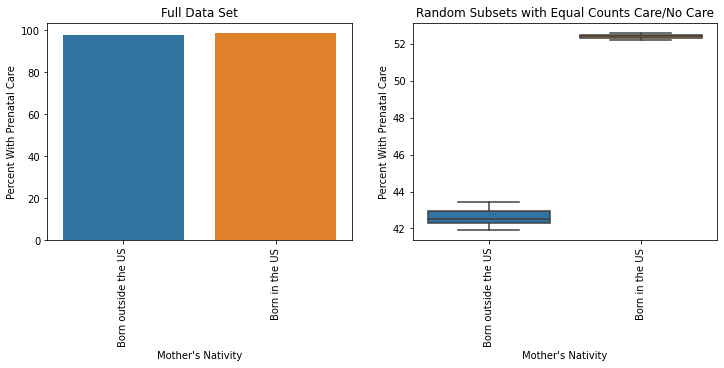

In [6]:
plot_care('mbstate_rec', "Mother's Nativity", nat_dict)

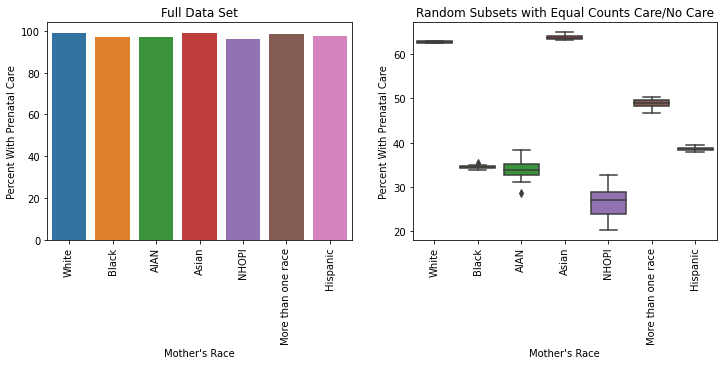

In [7]:
plot_care('mracehisp', "Mother's Race", race_dict)

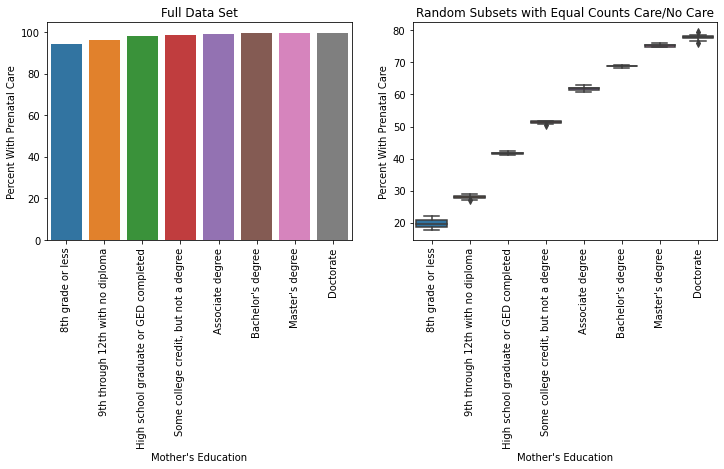

In [8]:
plot_care('meduc', "Mother's Education", educ_dict)

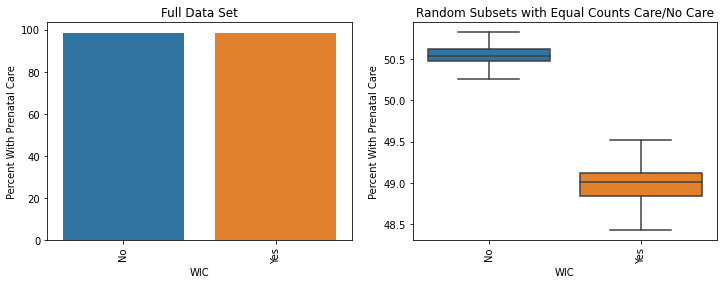

In [9]:
plot_care('wic', 'WIC', wic_dict)

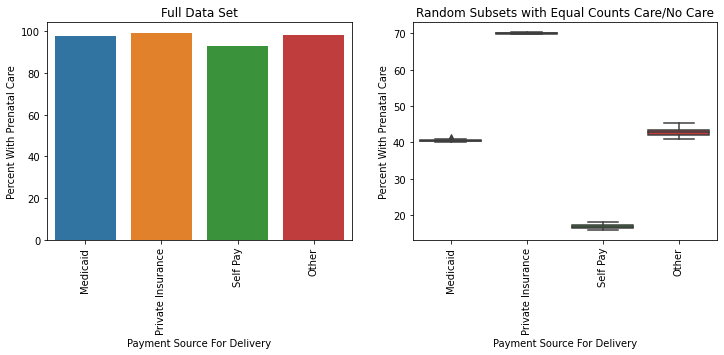

In [10]:
plot_care('pay_rec', 'Payment Source For Delivery', pay_dict)

## Can we predict who gets prenatal care?

In [11]:
group_dict = {
    0: [0],               # mbstate_rec
    1: [1],               # wic
    2: np.arange(2, 11),  # mager9
    3: np.arange(11, 18), # mracehisp
    4: np.arange(18, 26), # meduc
    5: np.arange(26, 30), # pay_rec
    6: [30]               # constant
}

group_name = {
    0: 'mbstate_rec',
    1: 'wic',
    2: 'mager9',
    3: 'mracehisp',
    4: 'meduc',
    5: 'pay_rec',
    6: 'constant'
}

def get_group(ii):
    for group in group_dict:
        if ii in group_dict[group]:
            return group

def add_label(ii):
    for group in group_dict:
        if ii == group_dict[group][0]:
            return True
    return False

In [23]:
# Define loss function
def loss(b, X, y, lam, group=False):
    Xb = X.dot(b)
    nll = (np.sum(np.log(1 + np.exp(Xb))) - y.dot(Xb))/X.shape[0]
    if group:
        return nll + lam*reg(b)
    return nll + lam*np.linalg.norm(b, 1)

# Define regularization function for group sparsity
def reg(b):
    reg_sum = 0
    for group in group_dict:
        b_sub = b[group_dict[group]]
        reg_sum += np.linalg.norm(b_sub, 2)/len(b_sub)
    return reg_sum

def print_message(X, y, res):
    y_pred = X.dot(res.x)
    y_pred = 1*(y_pred >= 0)
    accu = 100*sum(y_pred == y)/len(y)
    sens = 100*len(y_pred[(y_pred == 1) & (y == 1)])/len(y[y == 1])
    spec = 100*len(y_pred[(y_pred == 0) & (y == 0)])/len(y[y == 0])
    message = f"Converge: {res.success}, Prediction accuracy: {accu:.2f}%, "
    message += f"Sensitivity: {sens:.2f}%, Specificity: {spec:.2f}%"
    print(message)

### No regularization

In [24]:
coef_list = []
for seed in np.arange(25):
    df_who = get_subset(seed)

    # Create dummy variables
    data = pd.get_dummies(df_who, columns=['mager9', 'mracehisp', 'meduc', 'pay_rec'])
    data.drop(columns='precare5', inplace=True)

    # Create feature matrix and outcome vector
    y = data['prenatal'].values
    features = [col != 'prenatal' for col in data.columns]
    X = data.loc[:, features].values
    X = np.hstack((X, np.ones((X.shape[0], 1))))

    # Solution with no regularization
    res = minimize(lambda b: loss(b, X, y, 0, group=False), np.random.randn(31))
    coef_list.append(res.x)
    
    # Prediction accuracy
    print_message(X, y, res)
np.save('no_reg.npy', coef_list)

Converge: True, Prediction accuracy: 69.27%, Sensitivity: 68.66%, Specificity: 69.88%
Converge: True, Prediction accuracy: 69.45%, Sensitivity: 68.77%, Specificity: 70.14%
Converge: True, Prediction accuracy: 69.37%, Sensitivity: 68.88%, Specificity: 69.86%
Converge: True, Prediction accuracy: 69.12%, Sensitivity: 68.18%, Specificity: 70.06%
Converge: True, Prediction accuracy: 69.15%, Sensitivity: 68.39%, Specificity: 69.90%
Converge: True, Prediction accuracy: 69.20%, Sensitivity: 68.32%, Specificity: 70.09%
Converge: True, Prediction accuracy: 69.40%, Sensitivity: 68.91%, Specificity: 69.90%
Converge: True, Prediction accuracy: 69.19%, Sensitivity: 68.61%, Specificity: 69.76%
Converge: True, Prediction accuracy: 69.04%, Sensitivity: 68.32%, Specificity: 69.77%
Converge: True, Prediction accuracy: 69.32%, Sensitivity: 68.36%, Specificity: 70.28%
Converge: True, Prediction accuracy: 69.04%, Sensitivity: 67.84%, Specificity: 70.25%
Converge: True, Prediction accuracy: 68.76%, Sensitivi

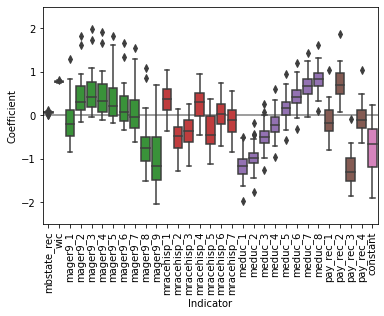

In [25]:
indicator_list = list(data.columns[features]) + ['constant']
temp = pd.DataFrame(columns=['indicator', 'coef'])
for ii, indicator in enumerate(indicator_list):
    coefs = [coefs[ii] for coefs in coef_list]
    temp = temp.append(pd.DataFrame({
        'indicator': [indicator]*len(coefs),
        'coef': coefs
    }), ignore_index=True)
    
fig, ax = plt.subplots()
my_pal = {indicator: my_cmap(get_group(ii)) for ii, indicator in enumerate(indicator_list)}
sns.boxplot(x='indicator', y='coef', data=temp, ax=ax, palette=my_pal)
ax.axhline(0, c='gray', zorder=0)
ax.set_xlabel('Indicator')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Coefficient')
ax.set_ylim([-2.5, 2.5]); # mager9_9 has lower outliers

### L1 Regularization

In [30]:
path_list = []
lam_list = np.logspace(-4, 0, 5)
for seed in np.arange(5):
    print(f"\nSeed: {seed}")
    df_who = get_subset(seed)

    # Create dummy variables
    data = pd.get_dummies(df_who, columns=['mager9', 'mracehisp', 'meduc', 'pay_rec'])
    data.drop(columns='precare5', inplace=True)

    # Create feature matrix and outcome vector
    y = data['prenatal'].values
    features = [col != 'prenatal' for col in data.columns]
    X = data.loc[:, features].values
    X = np.hstack((X, np.ones((X.shape[0], 1))))
    
    coef_list = []
    for ii, lam in enumerate(lam_list):
        # Solution with increasing regularization
        res = minimize(lambda b: loss(b, X, y, lam, group=False), np.random.randn(31))
        coef_list.append(res.x)
        
        # Prediction accuracy
        print_message(X, y, res)
        if not res.success:
            print(res.message)
    path_list.append(coef_list)
np.save('path_list_individual.npy', path_list)


Seed: 0
Converge: False, Prediction accuracy: 69.28%, Sensitivity: 68.75%, Specificity: 69.81%
Desired error not necessarily achieved due to precision loss.
Converge: False, Prediction accuracy: 69.28%, Sensitivity: 69.12%, Specificity: 69.44%
Desired error not necessarily achieved due to precision loss.
Converge: False, Prediction accuracy: 68.06%, Sensitivity: 68.52%, Specificity: 67.60%
Desired error not necessarily achieved due to precision loss.
Converge: False, Prediction accuracy: 66.02%, Sensitivity: 60.78%, Specificity: 71.26%
Desired error not necessarily achieved due to precision loss.
Converge: False, Prediction accuracy: 50.00%, Sensitivity: 0.00%, Specificity: 100.00%
Desired error not necessarily achieved due to precision loss.

Seed: 1
Converge: False, Prediction accuracy: 69.41%, Sensitivity: 68.86%, Specificity: 69.97%
Desired error not necessarily achieved due to precision loss.
Converge: False, Prediction accuracy: 69.38%, Sensitivity: 69.51%, Specificity: 69.25%
D

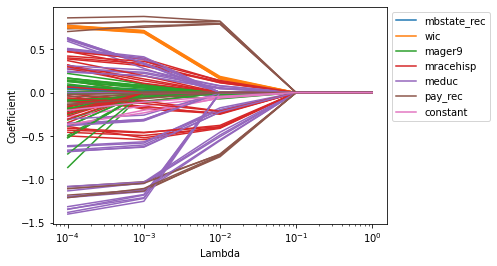

In [36]:
for kk, coefs in enumerate(path_list):
    coefs = np.array(coefs)
    c = [my_cmap(ii) for ii in group_dict for jj in group_dict[ii]]
    for ii in range(31):
        group = get_group(ii)
        if kk == 0 and add_label(ii):
            plt.semilogx(lam_list, coefs[:, ii], c=my_cmap(group), label=group_name[group])
        else:
            plt.semilogx(lam_list, coefs[:, ii], c=my_cmap(group))        
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Lambda')
    plt.ylabel('Coefficient');

1. (20) Private Insurance
2. (18) Hispanic, Constant
3. (17) Black, Self Pay, 9th through 12th with no diploma
4. (16) White, High school graduate or GED completed
5. (15) 15-19 years, Bachelor's degree, WIC
6. (14) Under 15 years, Some college credit, but not a degree, Master's degree, Medicaid

### Group Sparsity

In [41]:
path_list = []
lam_list = np.logspace(-4, 0, 5)
for seed in np.arange(5):
    print(f"\nSeed: {seed}")
    df_who = get_subset(seed)

    # Create dummy variables
    data = pd.get_dummies(df_who, columns=['mager9', 'mracehisp', 'meduc', 'pay_rec'])
    data.drop(columns='precare5', inplace=True)

    # Create feature matrix and outcome vector
    y = data['prenatal'].values
    features = [col != 'prenatal' for col in data.columns]
    X = data.loc[:, features].values
    X = np.hstack((X, np.ones((X.shape[0], 1))))
    
    coef_list = []
    for ii, lam in enumerate(lam_list):
        # Solution with increasing regularization
        res = minimize(lambda b: loss(b, X, y, lam, group=True), np.random.randn(31))
        coef_list.append(res.x)
        
        # Prediction accuracy
        print_message(X, y, res)
        if not res.success:
            print(res.message)
    path_list.append(coef_list)
np.save('path_list_group.npy', path_list)


Seed: 0
Converge: False, Prediction accuracy: 69.26%, Sensitivity: 68.66%, Specificity: 69.86%
Desired error not necessarily achieved due to precision loss.
Converge: True, Prediction accuracy: 69.26%, Sensitivity: 68.65%, Specificity: 69.88%
Converge: False, Prediction accuracy: 69.26%, Sensitivity: 69.27%, Specificity: 69.25%
Desired error not necessarily achieved due to precision loss.
Converge: False, Prediction accuracy: 67.68%, Sensitivity: 64.45%, Specificity: 70.91%
Desired error not necessarily achieved due to precision loss.
Converge: False, Prediction accuracy: 50.54%, Sensitivity: 1.45%, Specificity: 99.64%
Desired error not necessarily achieved due to precision loss.

Seed: 1
Converge: False, Prediction accuracy: 69.46%, Sensitivity: 68.77%, Specificity: 70.15%
Desired error not necessarily achieved due to precision loss.
Converge: False, Prediction accuracy: 69.40%, Sensitivity: 68.83%, Specificity: 69.98%
Desired error not necessarily achieved due to precision loss.
Con

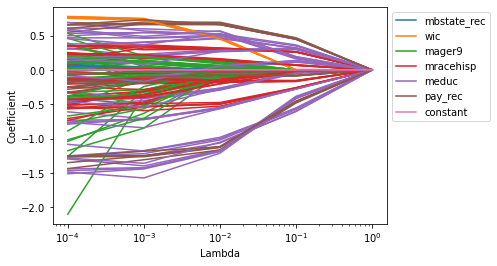

In [42]:
for kk, coefs in enumerate(path_list):
    coefs = np.array(coefs)
    c = [my_cmap(ii) for ii in group_dict for jj in group_dict[ii]]
    for ii in range(31):
        group = get_group(ii)
        if kk == 0 and add_label(ii):
            plt.semilogx(lam_list, coefs[:, ii], c=my_cmap(group), label=group_name[group])
        else:
            plt.semilogx(lam_list, coefs[:, ii], c=my_cmap(group))        
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Lambda')
    plt.ylabel('Coefficient');

Lambda: 1.0000e-04, Prediction accuracy: 69.26%, Converge: True
Lambda: 1.4678e-04, Prediction accuracy: 69.26%, Converge: True
Lambda: 2.1544e-04, Prediction accuracy: 69.27%, Converge: False
Lambda: 3.1623e-04, Prediction accuracy: 69.26%, Converge: True
Lambda: 4.6416e-04, Prediction accuracy: 69.27%, Converge: True
Lambda: 6.8129e-04, Prediction accuracy: 69.26%, Converge: True
Lambda: 1.0000e-03, Prediction accuracy: 69.28%, Converge: False
Lambda: 1.4678e-03, Prediction accuracy: 69.28%, Converge: False
Lambda: 2.1544e-03, Prediction accuracy: 69.28%, Converge: False
Lambda: 3.1623e-03, Prediction accuracy: 69.27%, Converge: False
Lambda: 4.6416e-03, Prediction accuracy: 69.25%, Converge: False
Lambda: 6.8129e-03, Prediction accuracy: 69.14%, Converge: True
Lambda: 1.0000e-02, Prediction accuracy: 69.05%, Converge: False
Lambda: 1.4678e-02, Prediction accuracy: 68.91%, Converge: False
Lambda: 2.1544e-02, Prediction accuracy: 68.91%, Converge: False
Lambda: 3.1623e-02, Prediction 

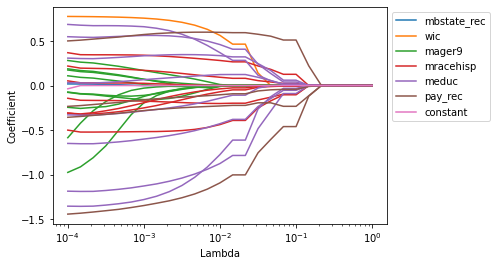

In [13]:
# old plot
x01_list = [res0.x]
for ii, lam in enumerate(lam_list):
    res = minimize(lambda b: loss(b, lam, True), x01_list[ii])
    y_pred = X.dot(res.x)
    y_pred = 1*(y_pred >= 0)
    print(f"Lambda: {lam:.4e}, Prediction accuracy: {100*sum(y_pred == y)/len(y):.2f}%, Converge: {res.success}") 
    x01_list.append(res.x)

coefs = np.array(x01_list)
for ii in range(31):
    group = get_group(ii)
    if add_label(ii):
        plt.semilogx(lam_list, coefs[1:, ii], c=my_cmap(group), label=group_name[group])
    else:
        plt.semilogx(lam_list, coefs[1:, ii], c=my_cmap(group))
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Lambda')
plt.ylabel('Coefficient');

1. (20) Payment method: (20) Private insurance, (18) Medicaid, (17) Self pay, (1) Other
2. (18) Constant
2. (18) Race: (18) Hispanic, (17) Black, (16) White, (11) Asian, (7) AIAN, (5) Mixed, (5) NHOPI
3. (17) Education: (17) 9th-12th no diploma, (16) high school or GED, (15) Bachelors, (14), 8th grade, (14) Master's, (13) COllege credit, (11) Doctorate, (5) Associates
4. (15) Age: 
4. (15) WIC
5. (6) Where born